In [1]:
## IMPORT ALL LIBRAIES...

import os
import copy
import pandas as pd 
import numpy as np 
import torch
import albumentations as A
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch.nn as nn 
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import Compose
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader 
import torchvision.models as models
from ImageProcess import SplitImages, checkingsplitsame
from ImageClfModeling import set_parameter_requires_grad, train_model

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#--------------------------------------------IMAGE PATH---------------------------------------------

# image path
train_imagepath = "TrainImage/train/"
test_imagepath = "TestImage/test/"

In [3]:
#--------------------------------------------INITIAL GLOBAL TRANSFORMATION---------------------------------------------

# global transformation into tensor form (train data)
global_transform = Compose([transforms.ToTensor()])
database_train = ImageFolder(root=train_imagepath, transform=global_transform)

In [4]:
# global transformation into tensor form (test data)
database_test = ImageFolder(root=test_imagepath, transform=global_transform)

In [5]:
# plotting tensor images

def tensorimageplot(tensorarray, caption=""):
    x = tensorarray.permute(1, 2, 0)
    plt.imshow(x) 
    plt.title(caption)
    plt.axis("off")

In [6]:
#--------------------------------------------CLASS LABELS TO INDEX---------------------------------------------

# class names from index to class
class_names = [x for x in database_train.classes]
class_name_dict = {}
for ix, val in enumerate(class_names):
    class_name_dict[ix] = val

In [7]:
#--------------------------------------------RANDOMIZED IMAGE SPLIT---------------------------------------------

# random images split 
valid_div = 10
test_div = 1
randomseed = 10
valid_sz = len(database_train)//valid_div
train_sz = len(database_train) - (len(database_train)//valid_div)
test_sz = len(database_test)

# train and valid
torch.manual_seed(randomseed)
train_ds, valid_ds = random_split(database_train, [train_sz, valid_sz])

# test
test_ds = random_split(database_test, [test_sz])[0]

In [8]:
# testing indices for test data with train data 
checkingsplitsame(train_ds, valid_ds, "Train")

Train: Datset is not Matching


In [9]:
#--------------------------------------------DATA AUGMENTATION---------------------------------------------

# train transformation 
print()
print("AUGMENTING TRAINING IMAGES")
print()
train_transform = A.Compose([A.HorizontalFlip(p=0.5), 
                            A.ImageCompression(quality_lower=99, quality_upper=100),
                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10,
                                              border_mode=0, p=0.7),
                            A.Resize(224, 224),
                            A.Cutout(max_h_size=int(224*0.4), max_w_size=int(224*0.4), 
                                    num_holes=1, p=0.65),
                            ToTensorV2()])

traindata_trans = []

for img, lb in tqdm(train_ds):
    im = train_transform(image=img.permute(1,2,0).numpy())
    traindata_trans.append((im["image"], lb))


AUGMENTING TRAINING IMAGES



/home/ubuntu/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


  0%|          | 0/11044 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.8/site-packages/albumentations/augmentations/functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


In [10]:
# validation transformation 
print()
print("AUGMENTING VALIDATION IMAGES")
print()
valid_transform = A.Compose([A.Resize(224, 244),
                            ToTensorV2()])

validdata_trans = []

for img, lb in tqdm(valid_ds):
    im = valid_transform(image = img.permute(1,2,0).numpy())
    validdata_trans.append((im["image"], lb))


AUGMENTING VALIDATION IMAGES



  0%|          | 0/1227 [00:00<?, ?it/s]

In [11]:
# test data transformation 
print()
print("AUGMENTING TEST IMAGES")
print()
test_transform = A.Compose([A.Resize(224, 244),
                            ToTensorV2()])

testdata_trans = []

for img, lb in tqdm(test_ds):
    im = test_transform(image = img.permute(1,2,0).numpy())
    testdata_trans.append((im["image"], lb))


AUGMENTING TEST IMAGES



  0%|          | 0/3068 [00:00<?, ?it/s]

In [12]:
#--------------------------------------------DATA LOADERS---------------------------------------------  


# batch size for train and validation data 
batch_size_ = 256

# batch size for test data (we want to test all the data at one go)
batch_test = len(test_ds)

# Iterative Data loader
train_dl = DataLoader(traindata_trans, batch_size=batch_size_, shuffle=True, num_workers=2)
valid_dl = DataLoader(validdata_trans, batch_size=batch_size_, shuffle=True, num_workers=2)
test_dl = DataLoader(testdata_trans, batch_size=batch_test, shuffle=False, num_workers=2)

In [13]:
#-------------------------------MODEL---------------------------------------


# Initialising the pre trained model
'''def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =  nn.Sequential(nn.Dropout(0.1),nn.Linear(num_ftrs,num_classes))
    return model_ft'''

'''def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_last_inp = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(model_last_inp, num_classes)
    return model_ft'''

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.vgg16(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] =  nn.Linear(num_ftrs,num_classes)
    return model_ft

In [14]:
#--------------------------------------INITIALIZING PRE TRAINED MODEL-----------------------------------


num_classes = len(class_name_dict)
feature_extract = False

# pre trained model
model_ft = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
#--------------------------------SENDING MODEL TO GPU-------------------------------------


# Send the model to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print(f'using {device} device')

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

using cuda device
Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [16]:
#--------------------------------MODEL PARAMETERS---------------------------------------------


# Epochs
epochs_ = 12

# learning rate
lr= 1e-3

# momentum
moment = 0.9

# Optimizer
optimizer_ft = torch.optim.SGD(params_to_update, lr=lr, momentum=moment)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [17]:
#----------------------------------- TRAIN & VALIDATE--------------------------------------

#dataloaders
dataloaders_dict ={}
dataloaders_dict['train']= train_dl
dataloaders_dict['valid'] = valid_dl

# Train and evaluate
model_ft, epoch_loss_train, epoch_acc_train, epoch_loss_valid, epoch_acc_valid  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, device, num_epochs=epochs_)

Epoch: 0| train loss: 406.0809326171875| valid loss: 357.3874816894531| train acc: 0.7457584142684937| valid acc: 0.7855218648910522
Epoch: 1| train loss: 357.4235534667969| valid loss: 316.2204284667969| train acc: 0.8042140603065491| valid acc: 0.8402786254882812
Epoch: 2| train loss: 324.5345458984375| valid loss: 283.42523193359375| train acc: 0.8387784361839294| valid acc: 0.8628694415092468
Epoch: 3| train loss: 299.9707946777344| valid loss: 277.1204833984375| train acc: 0.8595920205116272| valid acc: 0.8811768293380737
Epoch: 4| train loss: 279.0066223144531| valid loss: 249.55752563476562| train acc: 0.873046875| valid acc: 0.8998268246650696
Epoch: 5| train loss: 261.0922546386719| valid loss: 233.31887817382812| train acc: 0.8876558542251587| valid acc: 0.9094058275222778
Epoch: 6| train loss: 241.78915405273438| valid loss: 218.7655029296875| train acc: 0.9047901034355164| valid acc: 0.9276477694511414
Epoch: 7| train loss: 229.52969360351562| valid loss: 214.25521850585938

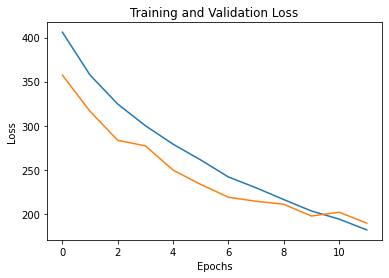

In [18]:
plt.plot(epoch_loss_train, label="Training Loss")
plt.plot(epoch_loss_valid, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

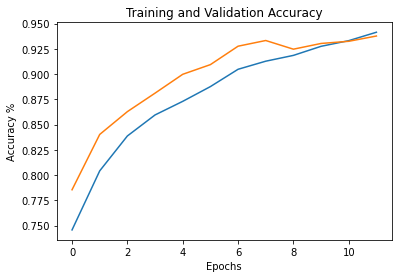

In [19]:
plt.plot(epoch_acc_train, label="Training Accuracy")
plt.plot(epoch_acc_valid, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

In [21]:
# save model
torch.save(model_ft.state_dict(), "VggNet_FER_weight.pt")